In [1]:
%pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


/bin/bash: /home/tinzitar/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # image size after resize
patch_size = 16  # Size of the patches
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim,]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
data_augment = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augment",
)
# Compute the mean and the variance of the training data for normalization.
data_augment.layers[0].adapt(x_train)

2022-06-29 18:41:37.354321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-29 18:41:38.045501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11194 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


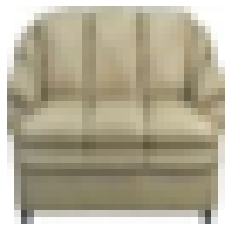

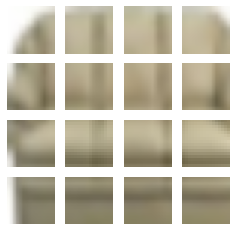

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [9]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augment(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [11]:
results = {}
def run_experiment(model, z):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    results{z}=(accuracy,top_5_accuracy)
    return history

for z in [4,6,8,10]:
    print(f'------------------------\n{z} layers\n------------------')
    tranformer_layers=z
    vit_classifier = create_vit_classifier()
    history = run_experiment(vit_classifier)

------------------------
4 layers
------------------
Epoch 1/100
176/176 [==============================] - 31s 133ms/step - loss: 4.2483 - accuracy: 0.0689 - top-5-accuracy: 0.2168 - val_loss: 3.6644 - val_accuracy: 0.1350 - val_top-5-accuracy: 0.3732
Epoch 2/100
176/176 [==============================] - 22s 127ms/step - loss: 3.7758 - accuracy: 0.1232 - top-5-accuracy: 0.3454 - val_loss: 3.4713 - val_accuracy: 0.1746 - val_top-5-accuracy: 0.4314
Epoch 3/100
176/176 [==============================] - 22s 125ms/step - loss: 3.5682 - accuracy: 0.1550 - top-5-accuracy: 0.4050 - val_loss: 3.2932 - val_accuracy: 0.2074 - val_top-5-accuracy: 0.4748
Epoch 4/100
176/176 [==============================] - 22s 127ms/step - loss: 3.4293 - accuracy: 0.1810 - top-5-accuracy: 0.4451 - val_loss: 3.1847 - val_accuracy: 0.2256 - val_top-5-accuracy: 0.5062
Epoch 5/100
176/176 [==============================] - 22s 126ms/step - loss: 3.3311 - accuracy: 0.1987 - top-5-accuracy: 0.4714 - val_loss: 3.0708

176/176 [==============================] - 22s 124ms/step - loss: 2.2648 - accuracy: 0.4012 - top-5-accuracy: 0.7219 - val_loss: 2.3048 - val_accuracy: 0.4176 - val_top-5-accuracy: 0.6988
Epoch 42/100
176/176 [==============================] - 22s 125ms/step - loss: 2.2622 - accuracy: 0.4038 - top-5-accuracy: 0.7241 - val_loss: 2.2787 - val_accuracy: 0.4116 - val_top-5-accuracy: 0.7074
Epoch 43/100
176/176 [==============================] - 22s 125ms/step - loss: 2.2441 - accuracy: 0.4043 - top-5-accuracy: 0.7295 - val_loss: 2.2835 - val_accuracy: 0.4248 - val_top-5-accuracy: 0.7024
Epoch 44/100
176/176 [==============================] - 22s 124ms/step - loss: 2.2451 - accuracy: 0.4024 - top-5-accuracy: 0.7279 - val_loss: 2.2823 - val_accuracy: 0.4134 - val_top-5-accuracy: 0.7060
Epoch 45/100
176/176 [==============================] - 22s 123ms/step - loss: 2.2232 - accuracy: 0.4110 - top-5-accuracy: 0.7310 - val_loss: 2.2948 - val_accuracy: 0.4136 - val_top-5-accuracy: 0.7018
Epoch 46

Epoch 82/100
176/176 [==============================] - 22s 124ms/step - loss: 1.9522 - accuracy: 0.4690 - top-5-accuracy: 0.7884 - val_loss: 2.1290 - val_accuracy: 0.4540 - val_top-5-accuracy: 0.7362
Epoch 83/100
176/176 [==============================] - 22s 123ms/step - loss: 1.9620 - accuracy: 0.4660 - top-5-accuracy: 0.7865 - val_loss: 2.1396 - val_accuracy: 0.4478 - val_top-5-accuracy: 0.7348
Epoch 84/100
176/176 [==============================] - 22s 124ms/step - loss: 1.9514 - accuracy: 0.4682 - top-5-accuracy: 0.7892 - val_loss: 2.1356 - val_accuracy: 0.4560 - val_top-5-accuracy: 0.7326
Epoch 85/100
176/176 [==============================] - 22s 123ms/step - loss: 1.9457 - accuracy: 0.4697 - top-5-accuracy: 0.7912 - val_loss: 2.1387 - val_accuracy: 0.4508 - val_top-5-accuracy: 0.7346
Epoch 86/100
176/176 [==============================] - 21s 122ms/step - loss: 1.9470 - accuracy: 0.4668 - top-5-accuracy: 0.7888 - val_loss: 2.1163 - val_accuracy: 0.4520 - val_top-5-accuracy: 0.

Epoch 22/100
176/176 [==============================] - 22s 125ms/step - loss: 2.6214 - accuracy: 0.3288 - top-5-accuracy: 0.6437 - val_loss: 2.5226 - val_accuracy: 0.3614 - val_top-5-accuracy: 0.6636
Epoch 23/100
176/176 [==============================] - 22s 124ms/step - loss: 2.6011 - accuracy: 0.3327 - top-5-accuracy: 0.6476 - val_loss: 2.5223 - val_accuracy: 0.3634 - val_top-5-accuracy: 0.6670
Epoch 24/100
176/176 [==============================] - 22s 124ms/step - loss: 2.5817 - accuracy: 0.3403 - top-5-accuracy: 0.6542 - val_loss: 2.5121 - val_accuracy: 0.3692 - val_top-5-accuracy: 0.6644
Epoch 25/100
176/176 [==============================] - 21s 122ms/step - loss: 2.5604 - accuracy: 0.3410 - top-5-accuracy: 0.6575 - val_loss: 2.4807 - val_accuracy: 0.3674 - val_top-5-accuracy: 0.6690
Epoch 26/100
176/176 [==============================] - 22s 123ms/step - loss: 2.5277 - accuracy: 0.3495 - top-5-accuracy: 0.6642 - val_loss: 2.4582 - val_accuracy: 0.3804 - val_top-5-accuracy: 0.

Epoch 63/100
176/176 [==============================] - 22s 126ms/step - loss: 2.0930 - accuracy: 0.4390 - top-5-accuracy: 0.7619 - val_loss: 2.2237 - val_accuracy: 0.4380 - val_top-5-accuracy: 0.7200
Epoch 64/100
176/176 [==============================] - 22s 123ms/step - loss: 2.0786 - accuracy: 0.4412 - top-5-accuracy: 0.7643 - val_loss: 2.2260 - val_accuracy: 0.4310 - val_top-5-accuracy: 0.7190
Epoch 65/100
176/176 [==============================] - 22s 124ms/step - loss: 2.0832 - accuracy: 0.4382 - top-5-accuracy: 0.7626 - val_loss: 2.2322 - val_accuracy: 0.4330 - val_top-5-accuracy: 0.7168
Epoch 66/100
176/176 [==============================] - 22s 123ms/step - loss: 2.0535 - accuracy: 0.4456 - top-5-accuracy: 0.7692 - val_loss: 2.2036 - val_accuracy: 0.4368 - val_top-5-accuracy: 0.7250
Epoch 67/100
176/176 [==============================] - 22s 123ms/step - loss: 2.0471 - accuracy: 0.4466 - top-5-accuracy: 0.7691 - val_loss: 2.2043 - val_accuracy: 0.4378 - val_top-5-accuracy: 0.

Epoch 3/100
176/176 [==============================] - 22s 125ms/step - loss: 3.5811 - accuracy: 0.1532 - top-5-accuracy: 0.4019 - val_loss: 3.2909 - val_accuracy: 0.2082 - val_top-5-accuracy: 0.4726
Epoch 4/100
176/176 [==============================] - 22s 123ms/step - loss: 3.4415 - accuracy: 0.1766 - top-5-accuracy: 0.4405 - val_loss: 3.1713 - val_accuracy: 0.2300 - val_top-5-accuracy: 0.5044
Epoch 5/100
176/176 [==============================] - 22s 126ms/step - loss: 3.3549 - accuracy: 0.1916 - top-5-accuracy: 0.4644 - val_loss: 3.0764 - val_accuracy: 0.2506 - val_top-5-accuracy: 0.5308
Epoch 6/100
176/176 [==============================] - 22s 123ms/step - loss: 3.2605 - accuracy: 0.2091 - top-5-accuracy: 0.4871 - val_loss: 3.0396 - val_accuracy: 0.2496 - val_top-5-accuracy: 0.5380
Epoch 7/100
176/176 [==============================] - 22s 127ms/step - loss: 3.2049 - accuracy: 0.2203 - top-5-accuracy: 0.5038 - val_loss: 2.9755 - val_accuracy: 0.2644 - val_top-5-accuracy: 0.5560


Epoch 44/100
176/176 [==============================] - 21s 122ms/step - loss: 2.2513 - accuracy: 0.4041 - top-5-accuracy: 0.7270 - val_loss: 2.2944 - val_accuracy: 0.4116 - val_top-5-accuracy: 0.7080
Epoch 45/100
176/176 [==============================] - 22s 125ms/step - loss: 2.2642 - accuracy: 0.4028 - top-5-accuracy: 0.7241 - val_loss: 2.2759 - val_accuracy: 0.4232 - val_top-5-accuracy: 0.7104
Epoch 46/100
176/176 [==============================] - 22s 123ms/step - loss: 2.2353 - accuracy: 0.4076 - top-5-accuracy: 0.7280 - val_loss: 2.2789 - val_accuracy: 0.4206 - val_top-5-accuracy: 0.7080
Epoch 47/100
176/176 [==============================] - 22s 123ms/step - loss: 2.2274 - accuracy: 0.4090 - top-5-accuracy: 0.7314 - val_loss: 2.2960 - val_accuracy: 0.4204 - val_top-5-accuracy: 0.7090
Epoch 48/100
176/176 [==============================] - 22s 123ms/step - loss: 2.2190 - accuracy: 0.4086 - top-5-accuracy: 0.7316 - val_loss: 2.2736 - val_accuracy: 0.4218 - val_top-5-accuracy: 0.

Epoch 85/100
176/176 [==============================] - 21s 122ms/step - loss: 1.9712 - accuracy: 0.4645 - top-5-accuracy: 0.7840 - val_loss: 2.1538 - val_accuracy: 0.4414 - val_top-5-accuracy: 0.7352
Epoch 86/100
176/176 [==============================] - 22s 125ms/step - loss: 1.9801 - accuracy: 0.4644 - top-5-accuracy: 0.7810 - val_loss: 2.1364 - val_accuracy: 0.4492 - val_top-5-accuracy: 0.7350
Epoch 87/100
176/176 [==============================] - 21s 121ms/step - loss: 1.9674 - accuracy: 0.4654 - top-5-accuracy: 0.7859 - val_loss: 2.1723 - val_accuracy: 0.4404 - val_top-5-accuracy: 0.7260
Epoch 88/100
176/176 [==============================] - 22s 123ms/step - loss: 1.9575 - accuracy: 0.4699 - top-5-accuracy: 0.7852 - val_loss: 2.1564 - val_accuracy: 0.4440 - val_top-5-accuracy: 0.7304
Epoch 89/100
176/176 [==============================] - 22s 124ms/step - loss: 1.9539 - accuracy: 0.4673 - top-5-accuracy: 0.7882 - val_loss: 2.1453 - val_accuracy: 0.4500 - val_top-5-accuracy: 0.

Epoch 25/100
176/176 [==============================] - 22s 124ms/step - loss: 2.5171 - accuracy: 0.3507 - top-5-accuracy: 0.6668 - val_loss: 2.4798 - val_accuracy: 0.3776 - val_top-5-accuracy: 0.6738
Epoch 26/100
176/176 [==============================] - 22s 125ms/step - loss: 2.5049 - accuracy: 0.3515 - top-5-accuracy: 0.6721 - val_loss: 2.4369 - val_accuracy: 0.3804 - val_top-5-accuracy: 0.6762
Epoch 27/100
176/176 [==============================] - 22s 124ms/step - loss: 2.4868 - accuracy: 0.3580 - top-5-accuracy: 0.6749 - val_loss: 2.4263 - val_accuracy: 0.3830 - val_top-5-accuracy: 0.6828
Epoch 28/100
176/176 [==============================] - 22s 123ms/step - loss: 2.4701 - accuracy: 0.3605 - top-5-accuracy: 0.6776 - val_loss: 2.4338 - val_accuracy: 0.3830 - val_top-5-accuracy: 0.6790
Epoch 29/100
176/176 [==============================] - 22s 124ms/step - loss: 2.4460 - accuracy: 0.3668 - top-5-accuracy: 0.6820 - val_loss: 2.3972 - val_accuracy: 0.3864 - val_top-5-accuracy: 0.

Epoch 66/100
176/176 [==============================] - 22s 123ms/step - loss: 2.0734 - accuracy: 0.4432 - top-5-accuracy: 0.7651 - val_loss: 2.2065 - val_accuracy: 0.4310 - val_top-5-accuracy: 0.7196
Epoch 67/100
176/176 [==============================] - 22s 123ms/step - loss: 2.0585 - accuracy: 0.4468 - top-5-accuracy: 0.7681 - val_loss: 2.2022 - val_accuracy: 0.4402 - val_top-5-accuracy: 0.7212
Epoch 68/100
176/176 [==============================] - 22s 123ms/step - loss: 2.0536 - accuracy: 0.4444 - top-5-accuracy: 0.7679 - val_loss: 2.2121 - val_accuracy: 0.4382 - val_top-5-accuracy: 0.7198
Epoch 69/100
176/176 [==============================] - 22s 122ms/step - loss: 2.0505 - accuracy: 0.4476 - top-5-accuracy: 0.7674 - val_loss: 2.2032 - val_accuracy: 0.4318 - val_top-5-accuracy: 0.7194
Epoch 70/100
176/176 [==============================] - 21s 122ms/step - loss: 2.0381 - accuracy: 0.4498 - top-5-accuracy: 0.7696 - val_loss: 2.2062 - val_accuracy: 0.4310 - val_top-5-accuracy: 0.

In [21]:
#keras.utils.plot_model(vit_classifier)

In [22]:
for i in results:
    print(f"{i} layers: test acc={results[i][0]}, test top5acc={results[i][0]}")


4 layers: test acc=46.56, test top5acc=46.56
6 layers: test acc=46.42, test top5acc=46.42
8 layers: test acc=46.65, test top5acc=46.65
10 layers: test acc=46.31, test top5acc=46.31


NameError: name 'model' is not defined